In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df_train = pd.read_csv('tmax_train.csv')
tmax_train = df_train['tmax']
tmax_train = np.reshape(tmax_train, (-1, 1))
tmax_train.shape

(437, 1)

In [35]:
df_test = pd.read_csv('tmax_test.csv')
tmax_test = df_test['tmax']
tmax_test = np.reshape(tmax_test, (-1, 1))
tmax_test.shape

(291, 1)

In [36]:
scaler = MinMaxScaler(feature_range=(0,1))
# Scaling dataset
scaled_train = scaler.fit_transform(tmax_train)
 
print(scaled_train[:5])

scaled_test = scaler.fit_transform(tmax_test)
print(*scaled_test[:5])

[[0.12852665]
 [0.13793103]
 [0.15360502]
 [0.14733542]
 [0.11912226]]
[0.39071038] [0.34153005] [0.37431694] [0.41530055] [0.37978142]


In [37]:
# Create sequences and labels for training data
# Number of time steps to look back
sequence_length = 50  
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i:i+sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train = X_train.cuda()
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = y_train.cuda()
X_train.shape,y_train.shape

(torch.Size([387, 50, 1]), torch.Size([387, 50, 1]))

In [38]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([261, 30, 1]), torch.Size([261, 30, 1]))

In [39]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [41]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
 
# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
 
loss_fn = torch.nn.MSELoss(reduction='mean')
 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [42]:
batch_size = 4
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
 
    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
 
    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
 
    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
 
        # Calculate average test loss and accuracy
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/50] - Training Loss: 0.0001, Test Loss: 0.0036
Epoch [20/50] - Training Loss: 0.0000, Test Loss: 0.0035
Epoch [30/50] - Training Loss: 0.0000, Test Loss: 0.0035
Epoch [40/50] - Training Loss: 0.0000, Test Loss: 0.0035
Epoch [50/50] - Training Loss: 0.0001, Test Loss: 0.0035


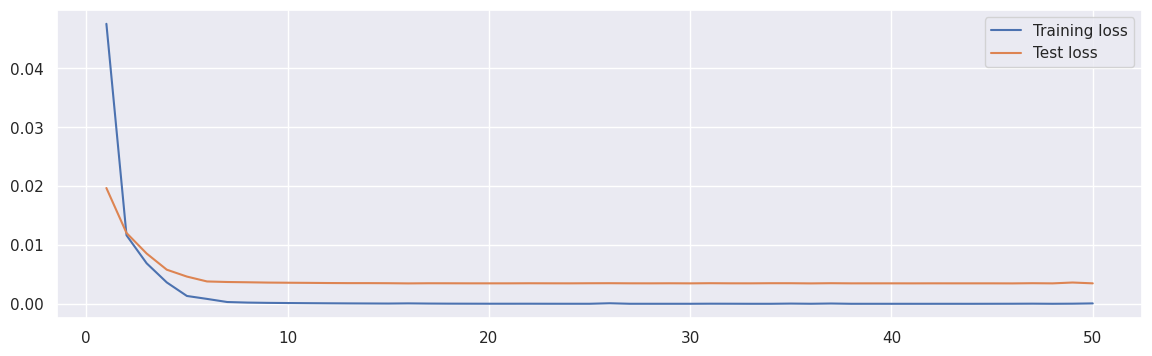

In [44]:
sns.set()
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [45]:
# Define the number of future time steps to forecast
num_forecast_steps = 30
 
# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()
 
# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)
 
# Initialize a list to store the forecasted values
forecasted_values = []
 
# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
 
        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])
 
        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value
         
# Generate future dates
last_date = pd.to_datetime('2022-03-15', format='%Y-%m-%d')

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
 
# Concatenate the original index with the future dates
combined_index = df_train.index.append(future_dates)
last_date

(30,)


Timestamp('2022-03-15 00:00:00')

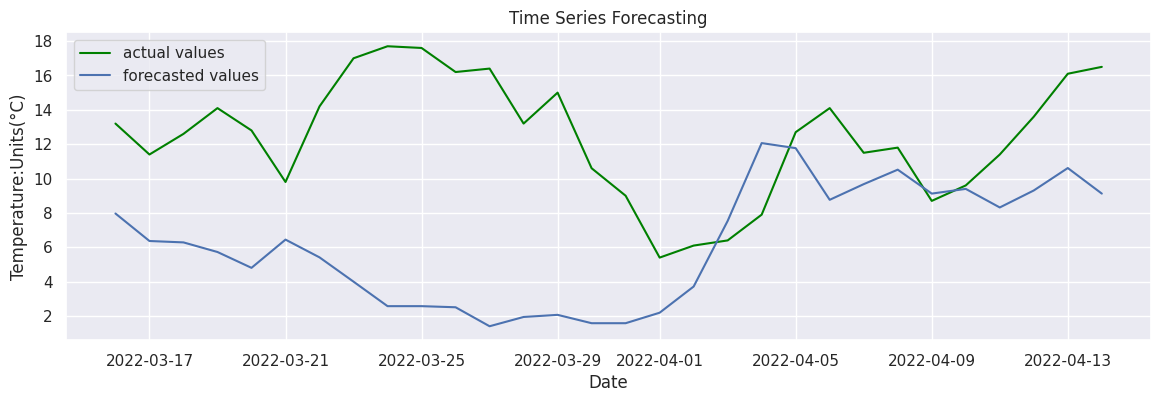

In [46]:
# Set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 

#reverse the scaling transformation
# original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 
 
# #the historical data used as input for forecasting
# plt.plot(combined_index[-30:], original_cases, label='actual values', color='green') 

plt.plot(combined_index[-30:], tmax_test[:30], label='actual values', color='green')
# Forecasted Values 
# Reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 

plt.plot(combined_index[-30:], forecasted_cases[-30:], label='forecasted values')  
 
plt.xlabel('Date')
plt.ylabel(r'Temperature:Units(' + chr(176) + 'C)')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

In [47]:
# Store the forecasted data in csv file
date = combined_index[-30:].astype(str)
date_list = []
for i in date:
    date_list.append(i.replace(' 00:00:00', ''))
    
forecasted_tmax = pd.DataFrame({'date':date_list, 'tmax': forecasted_cases[-30:]}) 
forecasted_tmax.to_csv('tmax_forecast.csv')